In [35]:
from tensorflow.keras.layers import Embedding
from numpy import unique
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
from tensorflow.keras.models import Model
import pandas as pd 
from sklearn.model_selection import train_test_split
data = './../../Data/Advance/basketball_data/games_season.csv'
games_season = pd.read_csv(data)
team_1 = games_season["team_1"]
team_2 = games_season["team_2"]

data = './../../Data/Advance/basketball_data/games_tourney.csv'
games_tourney = pd.read_csv(data)
# X_train_1, x_test_1, y_train, y_test = train_test_split(team_1, games_season)
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [36]:
# Count the unique number of teams
n_teams = unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

c:\Users\Shadow\anaconda3\envs\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Shared Layers
Shared layers require a functional API and are very flexible

In [37]:
# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name="Team-2-In")

# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

Merge Layers

In [38]:
# Imports
from tensorflow.keras.layers import Subtract

# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

Fiting and Predicting

In [39]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1,
          input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=0.1,
          verbose=True)

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12.1390 - val_loss: 11.8377


Prediction and Evaluation

In [40]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_1']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], games_tourney['score_diff'], verbose=False))

11.689183235168457


Multiple Inputs

In [41]:
from tensorflow.keras.layers import Concatenate
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [42]:
# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [43]:
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']], games_season['score_diff'], epochs=1, verbose=True,validation_split=0.1, batch_size=2048)
# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
          games_tourney['score_diff'], verbose=False))

138/138 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.1530 - val_loss: 11.7819
11.667893409729004


In [44]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Team-1-In           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Team-2-In           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Team-Strength-Model │ (None, 1)         │     10,888 │ Team-1-In[0][0],  │
│ (Functional)        │                   │            │ Team-2-In[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Home-In             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 3)         │          0 │ Team-Strength-Mo… │
│ (Concatenate)       │                   │            │ Team-Strength-Mo… │
│                     │                   │            │ Home-In[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          4 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,678 (127.65 KB)

 Trainable params: 10,892 (42.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,786 (85.11 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


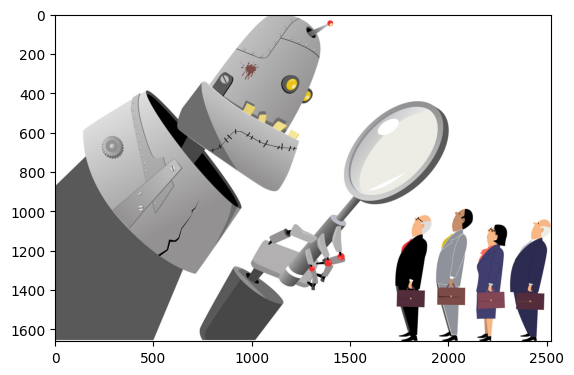

In [45]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Imports
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = 'model.png'
data=plt.imread(data)
plt.imshow(data)
plt.show()

Stacking models

In [54]:
 # Predict
x = model.predict([games_tourney['team_1'],games_tourney['team_2'],games_tourney['home']])
games_tourney['pred'] = x
games_tourney.to_csv('./../../Data/Advance/prediction_t.csv')


133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [13]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [14]:
games_tourney_train = games_tourney

In [ ]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.2917


In [16]:
# # Evaluate the model on the games_tourney_test dataset
# print(model.evaluate(games_tourney_test[['home','seed_diff','prediction']],
#                games_tourney_test['score_diff'], verbose=False))

In [17]:
# Define the input
input_tensor = Input(shape=(2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam',loss='mean_absolute_error')

In [18]:
# Fit the model
model.fit(games_tourney[['seed_diff', 'pred']],
  		  games_tourney[['score_1', 'score_2']],
  		  verbose=True,
  		  epochs=100,
  		  batch_size=16384)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 71.0461
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 71.0450
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 71.0438
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 71.0427
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 71.0416
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 71.0405
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 71.0394
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 71.0383
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 71.0371
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 71.0360
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 71.0349
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 71.0338
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 71.0327
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 71.0316
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 71.0304
Epo